ref: https://musicinformationretrieval.com/ipython_audio.html

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [4]:
import librosa
import librosa.display
import IPython.display as ipd

In [54]:
def strip_audio(x, frame_length=1024, hop_length=256, rms_ths=0.2):
    # compute energy
    energy = numpy.array([
        sum(abs(x[i:i+frame_length]**2))
        for i in range(0, len(x), hop_length)
    ])
    rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length)[0]
    rms_ratio = rmse/rmse.max()
    active_frames = np.nonzero(rms_ratio > rms_ths)[0]
    if len(active_frames) == 0:
        return x
    # strip continous active part
    s_sample = librosa.frames_to_samples(active_frames[0], hop_length=hop_length)[0]
    e_sample = librosa.frames_to_samples(active_frames[-1], hop_length=hop_length)[0]
    
    frames = range(len(energy))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
    librosa.display.waveplot(x, sr=sr, alpha=0.4)
    plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
    plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
    plt.legend(('Energy', 'RMSE'))

    return x[s_sample:e_sample], 

In [4]:
def _timeshift_audio(self, data):
    shift = (16000 * self.timeshift_ms) // 1000
    shift = random.randint(-shift, shift)
    a = -min(0, shift)
    b = max(0, shift)
    data = np.pad(data, (a, b), "constant")
    return data[:len(data) - a] if a else data[b:]

In [45]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))

NameError: name 'energy' is not defined

In [6]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/speech_commands/'
command_df = pd.read_pickle(os.path.join(dataframe_dir,'Command_Dataframe.pkl'))

In [44]:
test_df = command_df
for i, row in test_df.iterrows():
    file_path = os.path.join(data_dir, row.sent, row.file)
    save_path = 'test_audio/{}'.format(row.sent)
    if not os.path.exists(save_path): 
        os.makedirs('test_audio/{}'.format(row.sent))
    x, sr = librosa.load(file_path, sr=16000)
    striped_x = strip_audio(x, rms_ths=0.2)
    librosa.output.write_wav(os.path.join(save_path, row.file), striped_x, sr)

/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [37]:
set(ex_audio) - set(exist_files)

set()

In [40]:
len(set(ex_audio))

6412

In [21]:
exist_files = os.listdir('test_audio/')

ValueError: not enough values to unpack (expected 2, got 1)

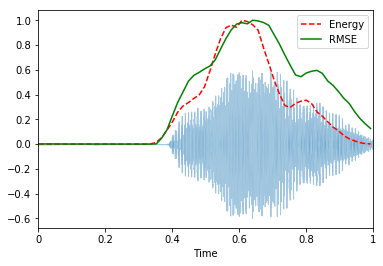

In [55]:
x, sr = librosa.load(file_path, sr=16000)
striped_x, fig = strip_audio(x, rms_ths=0.2)
ipd.Audio(data=striped_x,rate=sr) 

In [5]:
import librosa
x, sr = librosa.load("/home/muncok/DL/dataset/SV_sets/speech_commands_vad/bed/004ae714_nohash_0.wav", sr=16000)
ipd.Audio(data=x,rate=sr) 

In [7]:
len(x)

4352

***
### Check

In [ ]:
test_df

In [ ]:
import csv
import random

manifest_dir = "manifests/test"

samples = []
save_path = os.path.join(manifest_dir,'test_manifest.csv')
with open(save_path, 'w') as f:
    for index, row in test_df.iterrows():
#         file_path = os.path.join(data_dir, row.sent, row.file)
        file_path = "/home/muncok/DL/projects/sv_system/test_audio/{}".format(row.file)
        label = row.label
        sample = ','.join([file_path, str(label)])
        samples.append(sample)
    writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
    writer.writerow(samples)
    print("{} was written".format(save_path))

In [ ]:
import honk_sv.train as hk
from honk_sv import model as mod

In [ ]:
model = "cnn-trad-pool2"
dataset = "command"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0, 
                     n_epochs=30, batch_size=32,
                     lr=[0.001], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001, 
                     num_workers=8, print_step=100,
                     bn_size = 256)

builder = hk.ConfigBuilder(
                mod.find_config(model),
                mod.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
config = builder.config_from_argparse(parser)
config['model_class'] = mod.find_model(model)
hk.set_seed(config)

In [ ]:
config['n_labels'] = 2000
si_model = config['model_class'](config)
si_model.load("models/si_command_random_model.pt")
config['test_manifest'] = "manifests/test/test_manifest.csv"

In [ ]:
import torch.utils.data as data
_, _, test_set = mod.SpeechDataset.read_manifest(config)
test_loader = data.DataLoader(test_set, batch_size=config['batch_size'])

***

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
lstm = nn.LSTM(3,3)
inputs = [autograd.Variable(torch.randn((1,3)))
          for _ in range(5)]

# initialize the hidden state.
hidden = (autograd.Variable(torch.randn(1,1,3)),
         autograd.Variable(torch.randn((1,1,3))))

for i in inputs:
    out, hidden = lstm(i.view(1,1,-1), hidden)  # (1,3) --> (1,1,3)
    
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (autograd.Variable(torch.randn(1, 1, 3)), autograd.Variable(
    torch.randn((1, 1, 3))))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out) # print out all hidden state through sequence
print(hidden) # last hidden state, cell state

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)

training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

In [ ]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)), 
                autograd.Variable(torch.zeros(1,1,self.hidden_dim)))
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        # need to input initial hidden states
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space)
        return tag_scores

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Variables of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
# The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
#  for word i. The predicted tag is the maximum scoring tag.
# Here, we can see the predicted sequence below is 0 1 2 0 1
# since 0 is index of the maximum value of row 1,
# 1 is the index of maximum value of row 2, etc.
# Which is DET NOUN VERB DET NOUN, the correct sequence!
print(tag_scores)